In [1]:
%matplotlib qt

In [2]:
from ipywidgets import *
import matplotlib.pyplot as plt
# import matplotlib
# matplotlib.use('TkAgg')
import numpy as np
import pandas as pd

import mne

In [3]:
root = mne.datasets.sample.data_path() / "MEG" / "sample"
raw_file = root / "sample_audvis_filt-0-40_raw.fif"
raw = mne.io.read_raw_fif(raw_file, preload=False)

events_file = root / "sample_audvis_filt-0-40_raw-eve.fif"
events = mne.read_events(events_file)

raw.crop(tmax=90)  # in seconds (happens in-place)
# discard events >90 seconds (not strictly necessary, but avoids some warnings)
events = events[events[:, 0] <= raw.last_samp]

Opening raw data file /nethome/costamai/mne_data/MNE-sample-data/MEG/sample/sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.


In [4]:
#choose channels
raw.pick(["eeg", "eog"]).load_data()
raw.info

Reading 0 ... 13514  =      0.000 ...    90.001 secs...


<Info | 14 non-empty values
 bads: 1 items (EEG 053)
 ch_names: EEG 001, EEG 002, EEG 003, EEG 004, EEG 005, EEG 006, EEG 007, ...
 chs: 60 EEG, 1 EOG
 custom_ref_applied: False
 dev_head_t: MEG device -> head transform
 dig: 146 items (3 Cardinal, 4 HPI, 61 EEG, 78 Extra)
 highpass: 0.1 Hz
 hpi_meas: 1 item (list)
 hpi_results: 1 item (list)
 lowpass: 40.0 Hz
 meas_date: 2002-12-03 19:01:10 UTC
 meas_id: 4 items (dict)
 nchan: 61
 projs: Average EEG reference: off
 sfreq: 150.2 Hz
>

In [5]:
#not important - renaming
channel_renaming_dict = {name: name.replace(" 0", "").lower() for name in raw.ch_names}
_ = raw.rename_channels(channel_renaming_dict)  # happens in-place

In [6]:
#show channel locations
raw.plot_sensors(show_names=True)
fig = raw.plot_sensors("3d")

In [7]:
#see what it looked like before setting reference
for proj in (False, True):
    with mne.viz.use_browser_backend("matplotlib"):
        fig = raw.plot(
            n_channels=5, proj=proj, scalings=dict(eeg=50e-6), show_scrollbars=False
        )
    fig.subplots_adjust(top=0.9)  # make room for title
    ref = "Average" if proj else "No"
    fig.suptitle(f"{ref} reference", size="xx-large", weight="bold")

Using matplotlib as 2D backend.
Channels marked as bad:
['eeg53']
Channels marked as bad:
['eeg53']


In [8]:
raw.filter(l_freq=0.1, h_freq=None)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Filter length: 4957 samples (33.013 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


<Raw | sample_audvis_filt-0-40_raw.fif, 61 x 13515 (90.0 s), ~9.2 MB, data loaded>

In [9]:
#events codes
np.unique(events[:, -1])

array([ 1,  2,  3,  4,  5, 32])

In [10]:
# rename events and construct epochs using intervals around each time event
event_dict = {
    "auditory/left": 1,
    "auditory/right": 2,
    "visual/left": 3,
    "visual/right": 4,
    "face": 5,
    "buttonpress": 32,
}

epochs = mne.Epochs(raw, events, event_id=event_dict, tmin=-0.3, tmax=0.7, preload=True)
fig = epochs.plot(events=events)

Not setting metadata
132 matching events found
Setting baseline interval to [-0.2996928197375818, 0.0] s
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 132 events and 151 original time points ...
1 bad epochs dropped
You seem to have overlapping epochs. Some event lines may be duplicated in the plot.
Dropped 0 epochs: 
The following epochs were marked as bad and are dropped:
[]
Channels marked as bad:
['eeg53']


In [11]:
#reject epochs if a channel amplitude exceeds max value
reject_criteria = dict(eeg=100e-6, eog=200e-6)  # 100 µV, 200 µV
epochs.drop_bad(reject=reject_criteria)

    Rejecting  epoch based on EEG : ['eeg03']
    Rejecting  epoch based on EEG : ['eeg01', 'eeg02', 'eeg03', 'eeg04', 'eeg06', 'eeg07']
    Rejecting  epoch based on EEG : ['eeg01', 'eeg02', 'eeg03', 'eeg04', 'eeg06', 'eeg07']
    Rejecting  epoch based on EEG : ['eeg01', 'eeg02', 'eeg03', 'eeg04', 'eeg06', 'eeg07']
    Rejecting  epoch based on EEG : ['eeg01', 'eeg02', 'eeg03', 'eeg07']
    Rejecting  epoch based on EEG : ['eeg01', 'eeg02', 'eeg03', 'eeg07']
    Rejecting  epoch based on EEG : ['eeg01']
    Rejecting  epoch based on EEG : ['eeg03', 'eeg07']
    Rejecting  epoch based on EEG : ['eeg03', 'eeg07']
    Rejecting  epoch based on EEG : ['eeg07']
    Rejecting  epoch based on EEG : ['eeg03', 'eeg07']
    Rejecting  epoch based on EEG : ['eeg03', 'eeg07']
    Rejecting  epoch based on EEG : ['eeg07']
    Rejecting  epoch based on EEG : ['eeg07']
    Rejecting  epoch based on EEG : ['eeg03']
    Rejecting  epoch based on EEG : ['eeg25']
    Rejecting  epoch based on EEG : ['e

<Epochs | 114 events (all good), -0.3 – 0.699 s (baseline -0.3 – 0 s), ~11.0 MB, data loaded,
 'auditory/left': 25
 'auditory/right': 27
 'visual/left': 28
 'visual/right': 25
 'face': 5
 'buttonpress': 4>

In [12]:
#get the evoked responses we care about by filtering events and averaging epochs
l_aud = epochs["auditory/left"].average()
l_vis = epochs["visual/left"].average()

In [13]:
fig1 = l_aud.plot();
fig2 = l_vis.plot(spatial_colors=True);

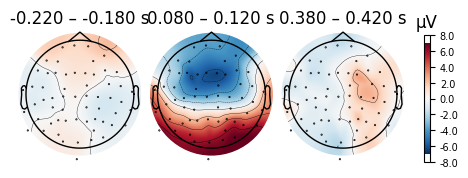

In [14]:
#display topomaps of the average evoked potential in 50 ms time windows centered at -200 ms, 100 ms, and 400 ms.
l_aud.plot_topomap(times=[-0.2, 0.1, 0.4], average=0.05)

Projections have already been applied. Setting proj attribute to True.


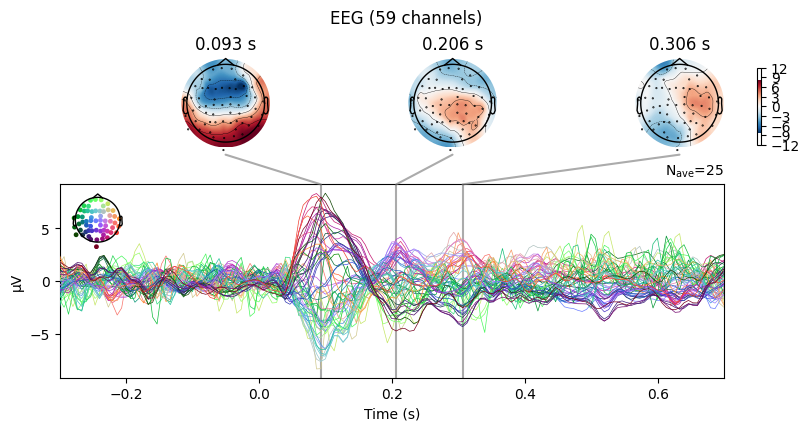

In [15]:
#see topomapson peak points together with butterflies plots 
l_aud.plot_joint()

In [16]:
plt.plot(l_aud.times * 1000, gfp * 1e6, color="lime")

NameError: name 'gfp' is not defined

In [38]:
# Calculate Global Field Power
gfp = l_aud.data.std(axis=0, ddof=0)
# Visualize GFP
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(l_aud.times * 1000, gfp * 1e6, color="lime")
ax.fill_between(l_aud.times * 1000, gfp * 1e6, color="lime", alpha=0.2)
ax.set(xlabel="Time (ms)", ylabel="GFP (µV)", title="Global Field Power")
ax.scatter(l_aud.times[min_idx[0]]*1000, gfp[min_idx[0]]* 1e6, label="minima")
ax.scatter(l_aud.times[max_idx[0]]*1000, gfp[max_idx[0]]* 1e6, label="minima", color = "r")

In [23]:
gfp.argmax()[1]

IndexError: invalid index to scalar variable.

In [21]:
l_aud.times[gfp.argmax()] 

0.093237766140581

In [37]:
from scipy.signal import argrelextrema
min_idx = argrelextrema(gfp, np.less)
max_idx = argrelextrema(gfp, np.greater)

min_idx, max_idx

((array([  2,   7,  10,  15,  17,  23,  26,  31,  37,  42,  47,  50,  52,
          71,  79,  83,  96,  99, 105, 112, 119, 121, 126, 133, 145, 149]),),
 (array([  5,   9,  12,  16,  20,  25,  28,  36,  39,  44,  49,  51,  59,
          76,  80,  91,  97, 103, 108, 117, 120, 123, 129, 139, 148]),))

In [27]:
gfp[min_idx[0]]

array([7.70304801e-07, 5.02524891e-07, 9.92243504e-07, 8.21826530e-07,
       8.26353480e-07, 7.13145995e-07, 6.72819614e-07, 6.01212979e-07,
       8.82691199e-07, 4.68687334e-07, 5.49527946e-07, 8.13154192e-07,
       9.88970849e-07, 8.04033780e-07, 1.86399794e-06, 1.15203111e-06,
       1.26701585e-06, 8.33349220e-07, 1.09527978e-06, 1.18612744e-06,
       1.41386867e-06, 1.40786559e-06, 1.01676916e-06, 1.07526004e-06,
       8.91639779e-07, 1.14207510e-06])

In [47]:
a = np.sort(gfp.argsort()[-3:])
a

array([58, 59, 60])

In [58]:
gfp.argsort()[-3:]

array([58, 60, 59])

In [63]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(gfp)
ax.scatter(gfp.argsort()[-3:], gfp[gfp.argsort()[-3:]])

In [54]:
idx = [1,3]
a = [10,20,30,40,50]


array([58, 59, 60,  5])

In [57]:
def segment(ts):
    #minima
    min_idx = argrelextrema(ts, np.less)
    min_vals = ts[min_idx[0]]

    # #inferior bound to be accepted as peak
    # thr = 1.4*min_vals.mean()

    #peaks - choose 3 of them 
    max_idx = argrelextrema(gfp, np.greater) #all peak candidates
    max_vals = ts[max_idx]
    peak_idx = np.sort(ts[max_ids].argsort()[-3:]) #peak index sorted in ascending order

    print("max_idx",max_idx)
    print("max_vals",max_vals)
    
    #add last index to be the last window limit
    max_idx = np.array(list(max_idx)+[len(ts)])
    
    min_repair_list = []
    id_left = 0
    for peak_id in max_idx:
        min_repair = min_vals[id_left:peak_id].mean()
        min_repair_list.append(min_repair)
        id_left = peak_id
    return min_repair_list

segment(gfp)

max_idx [58 59 60]
max_vals [4.52873753e-06 4.79005620e-06 4.59320723e-06]


/tmp/ipykernel_283564/2476400553.py:22: RuntimeWarning: Mean of empty slice.
  min_repair = min_vals[id_left:peak_id].mean()


[9.520298757544029e-07, nan, nan, nan]

In [74]:
x = np.array([1,10,3])

np.isin(np.argsort(x), [1,2])

array([False,  True,  True])

In [73]:
np.argsort(x)

array([0, 2, 1])